In [34]:
from models import vae_HYP, vae_EUCL
import geoopt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from hypmath import poincareball
import pandas as pd 
from tqdm import tqdm
import time

In [35]:
transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,))
        ])

trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET',
                              download=True, train=True, transform=transform)
testset = datasets.MNIST('PATH_TO_STORE_TESTSET',
                            download=True, train=False, transform=transform)

size = len(trainset)
#print(size)

#Splitting training set into training and validation data
train_data, val_data = torch.utils.data.random_split(trainset, [int(size-size*0.2), int(size*0.2)])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True, num_workers=6, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=256, num_workers=6, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True, num_workers=6, pin_memory=True)


In [36]:
model = vae_EUCL.VariationalAutoencoder(latent_dims=4)

In [37]:
learning_rate = 1e-3

In [38]:
optim = geoopt.optim.RiemannianAdam(model.parameters(), lr=learning_rate)
#optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [39]:
### Training function
def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        # x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        #ball = poincareball.PoincareBall()
        loss = ((x - x_hat)**2).sum() + (vae.encoder.kl)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [40]:
### Testing function
def test_epoch(vae, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            # x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [41]:
def plot_ae_outputs(encoder,decoder,n):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = testset[i][0].unsqueeze(0)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 43652.730469
	 partial train loss (single batch): 42666.562500
	 partial train loss (single batch): 41757.988281
	 partial train loss (single batch): 40965.625000
	 partial train loss (single batch): 40358.429688
	 partial train loss (single batch): 39754.085938
	 partial train loss (single batch): 39095.804688
	 partial train loss (single batch): 38513.218750
	 partial train loss (single batch): 38097.484375
	 partial train loss (single batch): 37620.316406
	 partial train loss (single batch): 37198.847656
	 partial train loss (single batch): 36792.285156
	 partial train loss (single batch): 36411.281250
	 partial train loss (single batch): 36067.488281
	 partial train loss (single batch): 35694.015625
	 partial train loss (single batch): 35338.863281
	 partial train loss (single batch): 35045.953125
	 partial train loss (single batch): 34722.937500
	 partial train loss (single batch): 34326.437500
	 partial train loss (single batch): 33959.531250


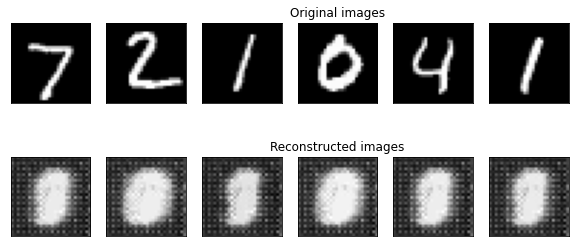

	 partial train loss (single batch): 15593.293945
	 partial train loss (single batch): 15312.163086
	 partial train loss (single batch): 15185.726562
	 partial train loss (single batch): 15634.814453
	 partial train loss (single batch): 15291.342773
	 partial train loss (single batch): 15402.917969
	 partial train loss (single batch): 15000.464844
	 partial train loss (single batch): 15022.625000
	 partial train loss (single batch): 15583.632812
	 partial train loss (single batch): 15405.666016
	 partial train loss (single batch): 15566.977539
	 partial train loss (single batch): 15004.012695
	 partial train loss (single batch): 15234.376953
	 partial train loss (single batch): 14883.698242
	 partial train loss (single batch): 15015.657227
	 partial train loss (single batch): 14858.694336
	 partial train loss (single batch): 15370.242188
	 partial train loss (single batch): 14816.629883
	 partial train loss (single batch): 15225.447266
	 partial train loss (single batch): 14863.459961


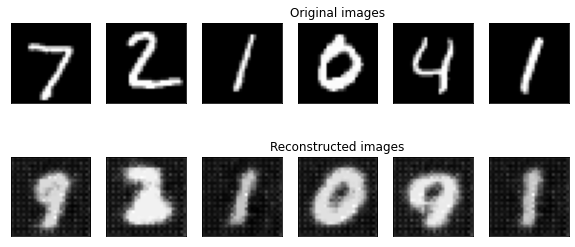

	 partial train loss (single batch): 12804.843750
	 partial train loss (single batch): 12726.597656
	 partial train loss (single batch): 12763.171875
	 partial train loss (single batch): 12578.533203
	 partial train loss (single batch): 13145.608398
	 partial train loss (single batch): 12939.536133
	 partial train loss (single batch): 13045.308594
	 partial train loss (single batch): 12729.962891
	 partial train loss (single batch): 12715.158203
	 partial train loss (single batch): 12837.944336
	 partial train loss (single batch): 12967.405273
	 partial train loss (single batch): 12736.707031
	 partial train loss (single batch): 12933.163086
	 partial train loss (single batch): 13226.619141
	 partial train loss (single batch): 12924.558594
	 partial train loss (single batch): 12800.740234
	 partial train loss (single batch): 12957.850586
	 partial train loss (single batch): 12826.452148
	 partial train loss (single batch): 12911.141602
	 partial train loss (single batch): 12861.637695


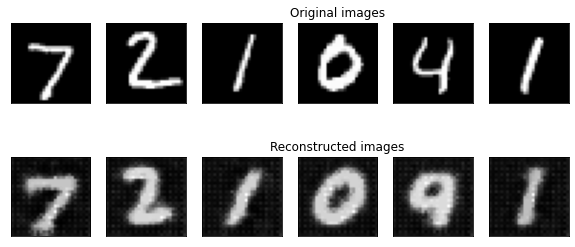

	 partial train loss (single batch): 12461.787109
	 partial train loss (single batch): 12375.613281
	 partial train loss (single batch): 12136.929688
	 partial train loss (single batch): 12092.949219
	 partial train loss (single batch): 12558.109375
	 partial train loss (single batch): 12247.798828
	 partial train loss (single batch): 12119.290039
	 partial train loss (single batch): 12577.798828
	 partial train loss (single batch): 12123.233398
	 partial train loss (single batch): 12110.923828
	 partial train loss (single batch): 12215.514648
	 partial train loss (single batch): 12050.848633
	 partial train loss (single batch): 11979.439453
	 partial train loss (single batch): 12162.908203
	 partial train loss (single batch): 11790.407227
	 partial train loss (single batch): 11909.957031
	 partial train loss (single batch): 12028.171875
	 partial train loss (single batch): 12218.792969
	 partial train loss (single batch): 12315.052734
	 partial train loss (single batch): 12198.991211


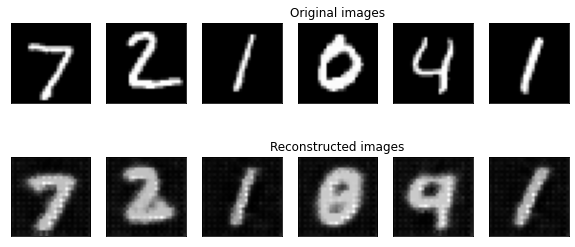

	 partial train loss (single batch): 11629.706055
	 partial train loss (single batch): 11323.068359
	 partial train loss (single batch): 11507.914062
	 partial train loss (single batch): 11480.907227
	 partial train loss (single batch): 11494.945312
	 partial train loss (single batch): 11505.280273
	 partial train loss (single batch): 11657.296875
	 partial train loss (single batch): 11411.291016
	 partial train loss (single batch): 11492.189453
	 partial train loss (single batch): 11490.970703
	 partial train loss (single batch): 11303.169922
	 partial train loss (single batch): 11670.028320
	 partial train loss (single batch): 11713.846680
	 partial train loss (single batch): 11486.769531
	 partial train loss (single batch): 11558.851562
	 partial train loss (single batch): 11601.993164
	 partial train loss (single batch): 11479.335938
	 partial train loss (single batch): 11582.100586
	 partial train loss (single batch): 11466.661133
	 partial train loss (single batch): 11729.292969


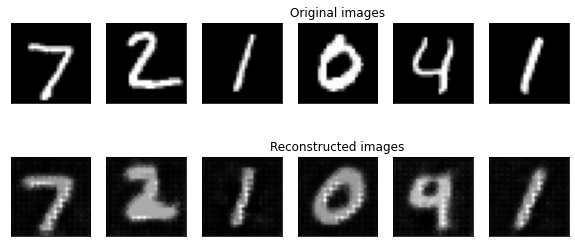

In [42]:
num_epochs = 5

for epoch in range(num_epochs):
   train_loss = train_epoch(model, trainloader,optim)
   val_loss = test_epoch(model, valloader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   plot_ae_outputs(model.encoder, model.decoder,n=6)




In [45]:
encoded_samples = []
for sample in tqdm(testset):
    img = sample[0].unsqueeze(0)
    label = sample[1]
    # Encode image
    model.eval()
    with torch.no_grad():
        encoded_img  = model.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)



from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
import plotly.express as px

#Davies-Bouldin Index
db_index = davies_bouldin_score(encoded_samples, encoded_samples.label)
print(db_index)

#Calinski-Harabasz Index
ch_score = calinski_harabasz_score(encoded_samples, encoded_samples.label)
print(ch_score)

#Silhouette Coefficient
s_coeff = silhouette_score(encoded_samples, encoded_samples.label)
print(s_coeff)

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

100%|██████████| 10000/10000 [00:07<00:00, 1342.52it/s]


1.2795999134949192
9722.907918024033
0.3466586966978306


TypeError: scatter() got an unexpected keyword argument 'z'

In [44]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()